# Word Vectors using SVD and TF-IDF

## Methodology

1. Loop over corpus and TF-IDF values in a matrix $X$
2. Apply SVD to get $X = USV^T$
3. Use the rows of $U$ as the word embeddings for all words in the dictionary (use the first $k$ columns to get $k$-dimensional word vectors)

Variance captured:

$$
\frac{\sum_{i=1}^k\sigma_i}{\sum_{j=1}^{|V|}\sigma_j}
$$

where $\sigma$ are the singular values of $X$ contained in the diagonal of $S$.

Issues:

- $X$ is very sparse since most words do not co-occur
- $X$ is very large - expensive to perform SVD (computational cost for $m\times n$ matrix is $\mathcal{O}(mn^2)$)

In [1]:
import os
import requests
from pathlib import Path
import gzip
import shutil
import string
import re
import collections
import time

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import KeyedVectors

import src.helper_functions as helper_functions

In [2]:
# Constants
DATASET_URL = "https://object.pouta.csc.fi/OPUS-Books/v1/mono/en.tok.gz"
VOCAB_SIZE = 10000 # Use 0 to set vocab size to number of unique words in the dataset (includes UNK token)
CONTEXT_SIZE = 2 # Size either side of target word
UNKNOWN_TOKEN = "<UNK>"
OUTPUT_SIZE = 300

## Dataset

[Link](https://object.pouta.csc.fi/OPUS-Books/v1/mono/en.tok.gz)

Reference: J. Tiedemann, 2012, Parallel Data, Tools and Interfaces in OPUS. In Proceedings of the 8th International Conference on Language Resources and Evaluation (LREC 2012)

### Fetch data

In [3]:
extracted_dataset_path = helper_functions.download_dataset(DATASET_URL)

Root folder: f:\dev\word-vectors
Extracted dataset found at f:\dev\word-vectors\data\books.txt


### Import and clean

In [4]:
lines = list()
with open(extracted_dataset_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

print("".join(lines[:5]))

Source : http : / / librosgratis.liblit.com /
Anna Karenina
Leo Tolstoy
VOLUME TWO PART V
CHAPTER I



In [5]:
print(helper_functions.clean_sentence("The quick  brown fox jumps over the lazy dog."))

the quick brown fox jumps over the lazy dog


In [6]:
cleaned_lines = [helper_functions.clean_sentence(line) for line in tqdm(lines, desc="Cleaning sentences")]
cleaned_lines = [line for line in tqdm(cleaned_lines, desc="Removing empty sentences") if len(line) > 0]

Removing empty sentences: 100%|██████████| 239555/239555 [00:00<00:00, 2304452.17it/s]


In [7]:
print("\n".join(cleaned_lines[:5]))

anna karenina
leo tolstoy
volume two part v
chapter i
the princess shcherbatskaya at first considered it out of the question to have the wedding before advent to which there remained but five weeks but could not help agreeing with levin that to put it off until after the fast might involve waiting too long for prince shcherbatsky s old aunt was very ill and likely to die soon and then the family would be in mourning and the wedding would have to be considerably deferred


### Tokenize and create vocabulary

In [8]:
raw_vocabulary = collections.Counter()
for sentence in tqdm(cleaned_lines, desc="Updating vocabulary"):
    raw_vocabulary.update(sentence.split())

Updating vocabulary: 100%|██████████| 239476/239476 [00:01<00:00, 155977.81it/s]


In [9]:
print(f"Raw vocab size: {len(raw_vocabulary)}")
print(raw_vocabulary.most_common(10))
assert raw_vocabulary[UNKNOWN_TOKEN] == 0, "Expect unknown word token to not be in vocabulary"

Raw vocab size: 80968
[('the', 271558), ('and', 146902), ('of', 135228), ('to', 134303), ('a', 98900), ('i', 76788), ('in', 75199), ('he', 66625), ('that', 64371), ('was', 60341)]


In [10]:
word_counts = np.array([count for _, count in raw_vocabulary.most_common()])

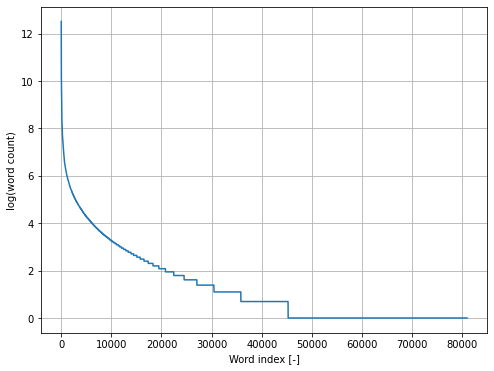

In [11]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.log(word_counts))
plt.grid(True)
plt.xlabel("Word index [-]")
plt.ylabel("log(word count)")
plt.show()

In [12]:
# Truncate vocab
word_list = list()
word_to_index = dict()
index_to_word = dict()
if VOCAB_SIZE > 0:
    truncated_word_list = [word for word, _ in raw_vocabulary.most_common(VOCAB_SIZE - 1)]
    truncated_vocabulary = collections.Counter()
    for sentence in tqdm(cleaned_lines, desc="Tokenizing sentences with truncated vocabulary"):
        words = [word if word in truncated_word_list else UNKNOWN_TOKEN for word in sentence.split()]
        word_list.append(words)
        truncated_vocabulary.update(words)

    print()
    print(f"Vocab size: {VOCAB_SIZE} | Coverage: {(sum(truncated_vocabulary.values()) - truncated_vocabulary[UNKNOWN_TOKEN]) / (sum(raw_vocabulary.values())) * 100:.1f}%")

    word_to_index = dict(zip(sorted(list(truncated_vocabulary)), range(VOCAB_SIZE)))
    del truncated_word_list, truncated_vocabulary
else:
    for sentence in tqdm(cleaned_lines, desc="Tokenizing sentences with full vocabulary"):
        word_list.append(sentence.split())

    word_to_index = dict(zip(sorted(list(raw_vocabulary)), range(len(raw_vocabulary))))

index_to_word = { v : k for (k, v) in word_to_index.items() }

del cleaned_lines

Tokenizing sentences with truncated vocabulary: 100%|██████████| 239476/239476 [01:46<00:00, 2251.41it/s]
Vocab size: 10000 | Coverage: 94.5%



## Compute TF-IDF matrix

In [13]:
vocab_size = len(raw_vocabulary)
if VOCAB_SIZE > 0:
    vocab_size = VOCAB_SIZE

del raw_vocabulary

# N = len(word_list)

# Only use 10000 longest sentences (memory issues)
sentence_lengths = [len(words) for words in word_list]
sorted_ind = sorted(range(len(sentence_lengths)), key=lambda k: sentence_lengths[k], reverse=True)
sorted_ind = sorted_ind[:10000]
N = len(sorted_ind)

# TODO: The top 10000 longest sentences may no longer include all the words in the truncated vocab
word_list_trunc = [word_list[ind] for ind in sorted_ind]
del word_list

term_freq = np.zeros((vocab_size, N), dtype=np.float)
for doc_index, words in enumerate(tqdm(word_list_trunc, desc="Computing term frequencies")):
    for word in words:
        term_freq[word_to_index[word], doc_index] += 1

inv_doc_freq = np.log(float(N) / (1 + np.sum(term_freq > 0, axis=1, keepdims=True)))

tf_idf = term_freq * inv_doc_freq
del term_freq, inv_doc_freq, word_list_trunc

Computing term frequencies: 100%|██████████| 10000/10000 [00:00<00:00, 12925.61it/s]


In [14]:
tf_idf[:10,:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
# Compute SVD
t_start = time.time()
U, sigma, _ = np.linalg.svd(tf_idf)
t_end = time.time()
print(f"Time taken for SVD: {t_end - t_start:.2f}s")

Time taken for SVD: 452.71s


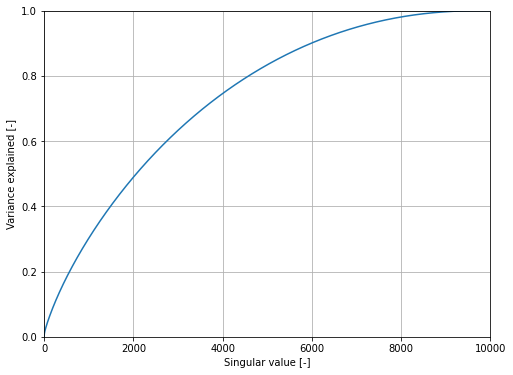

In [16]:
sum_sigma = np.sum(sigma)
var_explained = np.zeros(sigma.shape)
for i, val in enumerate(sigma):
    var_explained[i] = np.sum(sigma[:i]) / sum_sigma

fig = plt.figure(figsize=(8, 6))
plt.plot(var_explained)
plt.grid(True)
plt.xlabel("Singular value [-]")
plt.ylabel("Variance explained [-]")
plt.xlim([0, 10000])
plt.ylim([0, 1])
plt.show()

In [17]:
word_vectors = U[:, :OUTPUT_SIZE]
print(f"Variance explained: {var_explained[OUTPUT_SIZE - 1] * 100:.1f}%")

Variance explained: 12.3%


## Save output

Gensim loadable text file

In [18]:
output_filename = helper_functions.get_repo_root() / Path(f"models/word_vec_tfidf_svd_d{OUTPUT_SIZE}_v{VOCAB_SIZE}.txt")

with open(output_filename, "w", encoding="utf-8") as f:
    f.write(f"{len(word_to_index)} {OUTPUT_SIZE}\n")

    for word, index in tqdm(word_to_index.items(), desc="Writing output"):
        values = ["{:.8f}".format(v) for v in word_vectors[index, :]]
        values = " ".join(values)
        f.write(f"{word} {values}\n")

Writing output: 100%|██████████| 10000/10000 [00:03<00:00, 3254.17it/s]


## Import using gensim and analyse

In [19]:
model = KeyedVectors.load_word2vec_format(output_filename)
wv = model.wv
del model

In [20]:
wv.most_similar("1", topn=10)

[('2', 0.8508789539337158),
 ('3', 0.8093632459640503),
 ('6', 0.7701268196105957),
 ('blades', 0.7485184669494629),
 ('°', 0.7433404922485352),
 ('gideon', 0.7157309055328369),
 ('notebook', 0.7045023441314697),
 ('knives', 0.6906436681747437),
 ('carpenter', 0.661844789981842),
 ('spilett', 0.6579263210296631)]

In [21]:
wv.most_similar("cathedral", topn=10)

[('italian', 0.43843328952789307),
 ('arches', 0.41416847705841064),
 ('fantastic', 0.38307198882102966),
 ('towers', 0.3639177680015564),
 ('architect', 0.36390969157218933),
 ('tower', 0.3611716628074646),
 ('ix', 0.3533210754394531),
 ('monument', 0.35152119398117065),
 ('bordered', 0.34067195653915405),
 ('mass', 0.335146963596344)]

In [22]:
wv.most_similar("carpenter", topn=10)

[('3', 0.7760358452796936),
 ('2', 0.7739254832267761),
 ('6', 0.7566602826118469),
 ('blades', 0.715694785118103),
 ('gideon', 0.6923596858978271),
 ('notebook', 0.686211347579956),
 ('knives', 0.6753693222999573),
 ('tools', 0.6750668287277222),
 ('1', 0.6618447303771973),
 ('bags', 0.6546072959899902)]